# Tensor Decomposition in Videos

Quick overview of Tensor Decompositions and measures of difference in Videos.

## Agenda

### Javier:
- Progress made so far
- Problems faced
- Code

### Jean:
- Handwashing Dataset
- Exploratory Data Analysis
- Results

### Morsy:
- Related Work
- Moving forward



## Familiarization
 We got familiarized with the concepts involved in Tensor Decomposition. Mainly focusing on Tucker and CP Decomposition

## Testing

 A reproduction/implementation of the code from ["Video analusis with tensor decomposition in python" (2005 Hermez, Celestin)
](https://towardsdatascience.com/video-analysis-with-tensor-decomposition-in-python-3a1fe088831c)
 
## Problems

Inefficient code implementation: The code consumed all the RAM, was really slow to run

### Solution

* Exploring cloud implementations 

    - Google CoLab: Max 12 GB
    - Paperspace: 30 GB RAM 8 CORE (Limited availability)
* Reconstruction of the code, doing Garbage Colection to ease the use of RAM
    - Creation of the Tucker Decomposition Function

## Selection of Data Set

 The Hand Washing Data Set was selected for its light weight and simplicity 

# Implementation of Code


## Tucker Decomposition Function

In [1]:
# %% import packages
import cv2
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
import time

# %% define Tensor subset class?
class sub_tensor:
    """
    Class containing the tensor tucker rank=[2,2,2,2] decomposition of a certain video.
    
    Parameters
    ----------
    video_array: array 
        Complete or sampled section of a certain video
    rng: range
        Range from where the video frames were sampled. Used mainly for recovery purposes.
    video_name: string
        Name of the video
        
    Returns
    -------
    Tensor object containing the video_name,
    sample inclusion distribution used and the core and factors tucker rank=[2,2,2,2] decomposition
    """
    def __init__(self, video_array, rng, video_name):
        self.video_name = video_name
        self.rng = rng
        SubsetTensor = tl.tensor(video_array).astype('d')
        self.core, self.factors = tucker(SubsetTensor, ranks = [2,2,2,2])

# %% define Tucker Decomposition Function
def TuckerFunction(video_address, tensor_length=50, seed_state=None, max_frames=None):
    """
    Returns an object reprensenting the Tucker Decomposition on rank=[2,2,2,2] this done for a 
    sample from the frames of the original provided video. 
    
    Parameters
    ----------
    video_capture: string 
        Complete or relative path of the video
    tensor_length: integer, optional
        Length of the subsampled tensor to be decomposed and outpuded, 
        if not specified it will be set to 50 frames per default
    seed_state: numpy.random.RandomState, optional
        Object giving a random seed state,
        if not specified it will take the time as an integer and create a random seed
    max_frames: integer, optional
        Maximun number of frames to consider for analysis.
        If this is not specified, it wil simply take the whole maximun number of frames as is. 
    
    Returns
    -------
    Tensor object of class TuckerFunction.sub_tensor from the provided video
    """
    video_capture = cv2.VideoCapture(video_address)
    # Check how long the video will be
    if max_frames is None:
        max_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    # Initialize empty array
    frames_array = []
    
    # Keep track of the frame number
    frame_nb = 0
    
    # iterate through the frames and append them to the array
    while video_capture.isOpened() and frame_nb < max_frames:
        ret, frame = video_capture.read()
        if not ret:
            break
        frames_array.append(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        frame_nb += 1
    
    # release the video capture
    video_capture.release()
    cv2.destroyAllWindows()
    
    # release video from memory 
    del(video_capture)

    # set fixed seed for reproducibility
    if seed_state is None:
        seed_state = np.random.RandomState(int(time.time()))
    
    # subset array by taking frame sample
    rng = seed_state.choice(range(0,max_frames), tensor_length)
    frames_array=np.asarray(frames_array)[rng,:,:,:]
    
    # make tensor and decomposition (See class "sub_tensor" desambiguation up)
    tensor_decomposition = sub_tensor(video_array=frames_array, rng=rng, video_name = video_address)

    # return the tensor object 
    return(tensor_decomposition)

# Implementation on the cloud

Use the cloud capabilities and computer all the decompositions once and stored them as objects (easier to implement than Data Base)

In [2]:
import cv2
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from TuckerFunction import TuckerFunction
import pickle # For file writing
import glob # For File searching

video_list  = glob.glob('Videos/*.MOV') # Reading all files with MOV extension
video_list2 = glob.glob('Videos/*.mp4')
video_list = [] # List to store video names
# %% Loop for object creation

i = 0 # First List Index

if video_list:
    for video in video_list:
        decomp = TuckerFunction(video_list[i])
        pickle_out = open(video_list[i].replace('.MOV','').replace('Videos/','Decompositions/'),"wb")
        pickle.dump(decomp, pickle_out)
        pickle_out.close()
        video_list.append(video_list[i].replace('.MOV','').replace('Videos/','Decompositions/'))
        i = i + 1
j = 0    # Second list index
if video_list2:
    for video in video_list2:
        decomp = TuckerFunction(video_list2[j])
        pickle_out = open(video_list2[j].replace('.mp4','').replace('Videos/','Decompositions/'),"wb") # We use Main index for naming
        pickle.dump(decomp, pickle_out)
        pickle_out.close() 
        video_list.append(video_list2[j].replace('.mp4','').replace('Videos/','Decompositions/'))
        j = j + 1
# %% Saving List as an object
pickle_out = open('video_list',"wb") # We use Main index for naming
pickle.dump(video_list, pickle_out)
pickle_out.close() 

# Analyzing differences between videos as Tensors

In this section we are putting into use the previously designed function to analyze embody the difference between videos by using *Tucker Decomposition* to represent the Tensor Objects and the norm between core difference as a measure of difference.

## Data set

For the purpose of analysis we hand picked a standard data set to make comparisons. The [Sample: Hand Wash Dataset](https://www.kaggle.com/realtimear/hand-wash-dataset) from Kaggle, is a video Sample data-set (5%) of the video clips of the WHO prescribed a hand wash procedure.

Description from the data-set website:

### Content

The Hand Wash Dataset consists of 300 individual videos of hand washes (with each hand wash having 12 steps, in different environments to provide as much variance as possible. The varied parameters are:

* Illumination
* Background
* Source Camera Position
* Field of view
* Individuals performing the hand wash

This was done because the Hand Wash Dataset intends to simulate the real-world constraints of a potential application of an action recognition solution such as: fixed camera position, real-time feedback, varying illumination, static background and applied to one domain-specific fine-grained action task. The next step was to identify each step involved in the procedure. Hence, the original 7 Steps prescribed by the WHO were further broken down into 12 actions which take into account every possible action that may be performed when a person washes their hands.

![Example Visualization of the Data-set](Sample-HandWashDataset.png)

![Sink Types Example](SinkTypes.jpg)

For simplification we took a subset of the steps to analyze and precomputed the Tucker Decomposition over a $ranks = [2,2,2,2]$ and saved it on disk. From the 12 steps we selected the following:

* Step 1 (Represented as 1)
* Step 2 Left (Represented as 2)
* Step 3 (Represented as 4)

All the videos from this steps were cosidered for the current analysis.

# Difference computation

For the current part not much will be described (It's mostly retriving information from disk and doing comparisons).

In [3]:
# %% importing required packages
import pickle
import glob
import tensorly as tl
from TuckerFunction import TuckerFunction, sub_tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [14]:
# Defining commodity functions for dataframe formating
def Label(Num):
    """
    Parameters
    ----------
    Num: Integer
        Encoded number from video name that refers to the type of sink on the video.
    
    Returns
    -------
        Type of sink from the video
    """
    Num = int(Num)
    Label=""
    if Num<=5: Label="DarkSteelSink1"
    elif Num<=8: Label = "LightSteelSink1"
    elif Num<=11: Label = "CeramicSink1"
    elif Num<=14: Label = "SmallCeramicSink6"
    elif Num<=17: Label = "LightGraniteSink1"
    elif Num<=25: Label = "CeramicSink2"
    else: Label = "ERROR"
    return Label

def ReformatString(Data):
    """
    Parameters
    ----------
    Data: pandas.core.frame.DataFrame
        Splitted column of video names to be reformated
    
    Returns
    -------
        (pandas.core.frame.DataFrame) Data frame only with Type and Step number information
    """
    temp = np.empty(len(Data), dtype=object)
    for i in range(len(Data)):
        temp[i]=Label(Data[1][i])
    Data["Type"] = temp
    Data["Step"] = Data[3]
    for i  in range(6):
        del Data[i]
    return Data

# Looking for all decompositions on path
name_list  = glob.glob('*')
name_list = [n for n in name_list if "HandWash_" in n]
Tensor_List = []

# Load all tensor decompositions on memory
for tensor in name_list:
    Handler = open(tensor,"rb")
    Tensor_List.append(pickle.load(Handler))

# Create empty data-set to store core comparisons
Comparisons = pd.DataFrame(columns=["Left","Right","Difference"],dtype=float)

# Execute comparisons
n=len(Tensor_List)
for i in range(n):
    for j in range(n):
        if i == j:
            Append = pd.Series([Tensor_List[i].video_name, Tensor_List[j].video_name, 0], index=Comparisons.columns)
            Comparisons = Comparisons.append(Append, ignore_index=True)
        else:
            Append = pd.Series([Tensor_List[i].video_name, Tensor_List[j].video_name, tl.norm(Tensor_List[i].core - Tensor_List[j].core)], index=Comparisons.columns)
            Comparisons = Comparisons.append(Append, ignore_index=True)
            
# Reformat data-frame
Left = ReformatString(Comparisons["Left"].str.split("_", expand=True))
Right = ReformatString(Comparisons["Right"].str.split("_", expand=True))

Comparisons["Left Type"] = Left["Type"] 
Comparisons["Left Step"] = Left["Step"]
Comparisons["Right Type"] = Right["Type"] 
Comparisons["Right Step"] = Right["Step"]

Quick visualization of `Comparisons` table

In [20]:
Comparisons

,Left,Right,Difference,Left Type,Left Step,Right Type,Right Step
0,Videos/HandWash_001_A_01_G01.mp4,Videos/HandWash_001_A_01_G01.mp4,0.000000e+00,DarkSteelSink1,01,DarkSteelSink1,01
1,Videos/HandWash_001_A_01_G01.mp4,Videos/HandWash_001_A_02_G_01.mp4,1.222018e+06,DarkSteelSink1,01,DarkSteelSink1,02
2,Videos/HandWash_001_A_01_G01.mp4,Videos/HandWash_001_A_04_G_01.mp4,4.023628e+05,DarkSteelSink1,01,DarkSteelSink1,04
3,Videos/HandWash_001_A_01_G01.mp4,Videos/HandWash_002_A_01_G01.mp4,1.241731e+06,DarkSteelSink1,01,DarkSteelSink1,01
4,Videos/HandWash_001_A_01_G01.mp4,Videos/HandWash_002_A_02_G_01.mp4,2.417482e+04,DarkSteelSink1,01,DarkSteelSink1,02
...,...,...,...,...,...,...,...
5620,Videos/HandWash_025_A_04_G_05.mp4,Videos/HandWash_024_A_02_G_05.mp4,4.212325e+04,CeramicSink2,04,CeramicSink2,02
5621,Videos/HandWash_025_A_04_G_05.mp4,Videos/HandWash_024_A_04_G_05.mp4,3.919478e+06,CeramicSink2,04,CeramicSink2,04
5622,Videos/HandWash_025_A_04_G_05.mp4,Videos/HandWash_025_A_01_G05.mp4,8.857522e+05,CeramicSink2,04,CeramicSink2,01
5623,Videos/HandWash_025_A_04_G_05.mp4,Videos/HandWash_025_A_02_G_05.mp4,3.999605e+06,CeramicSink2,04,CeramicSink2,02


In [19]:
Comparisons["Difference"].describe()

count    5.625000e+03
mean     1.541412e+06
std      1.036104e+06
min      0.000000e+00
25%      7.958897e+05
50%      1.397343e+06
75%      2.365362e+06
max      4.134067e+06
Name: Difference, dtype: float64

## Difference visualization

Without further ado the difference computations from the comparisons bellow:

In [5]:
# %% View Results
Comp_Matrix = pd.pivot_table(Comparisons, values='Difference', index='Left', columns='Right', aggfunc=np.mean)

# Comparing all from Step 01
Filter = (Comparisons["Left Step"] == '01') & (Comparisons["Right Step"] == '01')
Comp_Step_01 = pd.pivot_table(Comparisons[Filter], values='Difference', index='Left', columns='Right', aggfunc=np.mean)

# Comparing all from DarkSteelSink1
Filter = (Comparisons["Left Type"] == 'DarkSteelSink1') & (Comparisons["Right Type"] == 'DarkSteelSink1')
Comp_DarkSteelSink1 = pd.pivot_table(Comparisons[Filter], values='Difference', index='Left', columns='Right', aggfunc=np.mean)

# Comparing between steps
Comp_Step = pd.pivot_table(Comparisons, values='Difference', index='Left Step', columns='Right Step', aggfunc=np.mean)

# Comparing between Types
Comp_Type = pd.pivot_table(Comparisons, values='Difference', index='Left Type', columns='Right Type', aggfunc=np.mean)




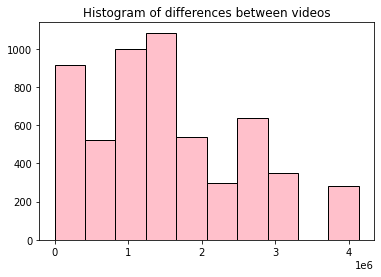

In [21]:
# Histogram of difference
plt.hist(Comparisons["Difference"], color='pink', ec='black')
plt.title("Histogram of differences between videos")
plt.show()


[Text(0.5, 1.0, 'Step average difference')]

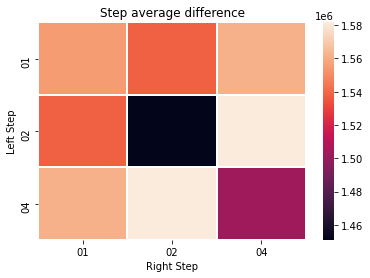

In [6]:
sns.heatmap(Comp_Step, linewidths=1).set(title="Step average difference")

[Text(0.5, 1.0, 'Type of sink average difference')]

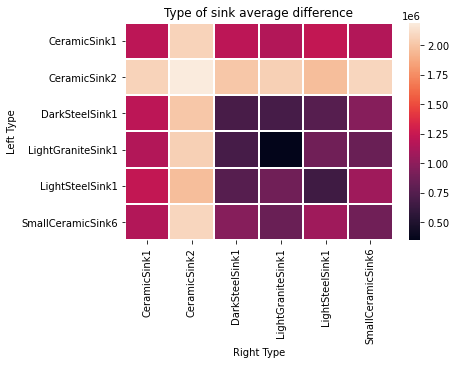

In [7]:
sns.heatmap(Comp_Type, linewidths=1).set(title="Type of sink average difference")

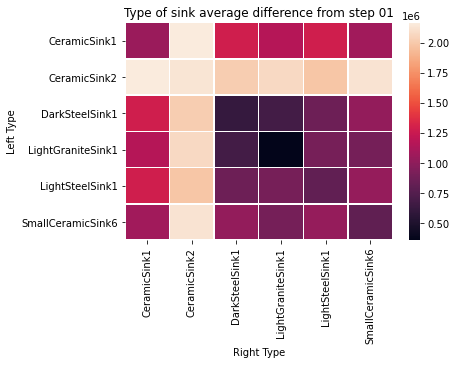

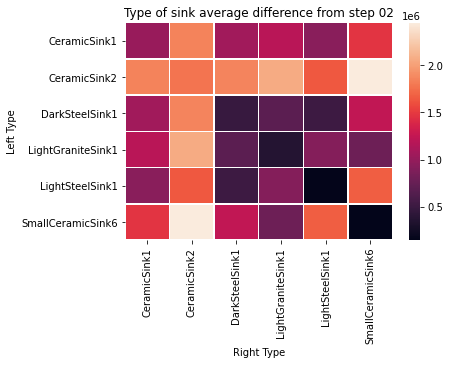

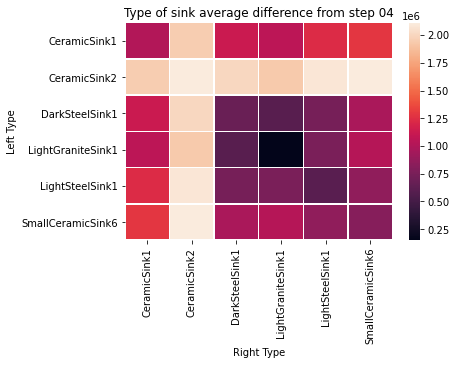

In [8]:
for step  in ["01","02","04"]:
    Filter = (Comparisons["Left Step"] == step) & (Comparisons["Right Step"] == step)
    Comp_Step_Type = pd.pivot_table(Comparisons[Filter], values='Difference', index='Left Type', columns='Right Type', aggfunc=np.mean)
    sns.heatmap(Comp_Step_Type,linewidths=0.5).set(title="Type of sink average difference from step "+step)
    plt.show()

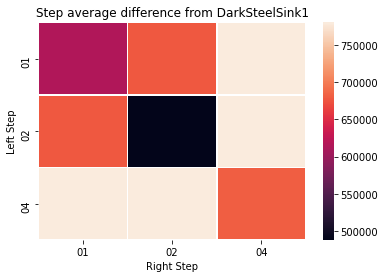

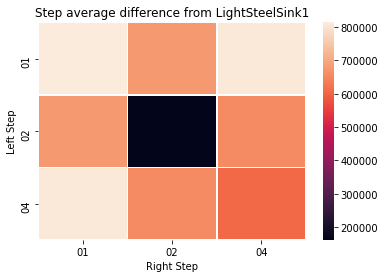

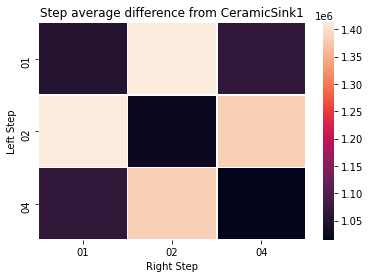

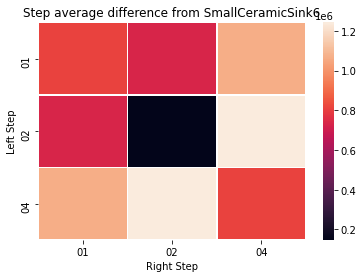

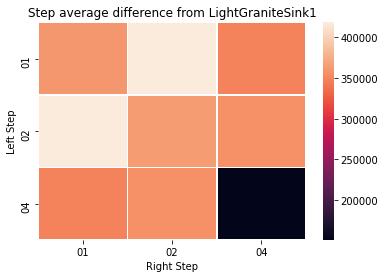

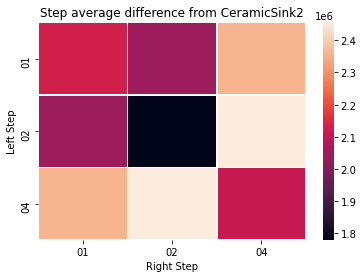

In [9]:
All_Types = pd.unique(Comparisons["Right Type"])

for Type  in All_Types:
    Filter = (Comparisons["Left Type"] == Type) & (Comparisons["Right Type"] == Type)
    Comp_Type_Step = pd.pivot_table(Comparisons[Filter], values='Difference', index='Left Step', columns='Right Step', aggfunc=np.mean)
    sns.heatmap(Comp_Type_Step,linewidths=0.5).set(title="Step average difference from "+Type)
    plt.show()

# Related work and next steps

For further steps many papers were considered to provide certain inspiration on what to do next. Even though, due to a complexity of them we had to constraint this list in many iterations. The following section will describe our top candidates of reproducible next steps.

## Proposed paper

1. Perceptual video hashing based on Tucker decomposition with application to indexing and retrieval of near-identical videos

* Sandeep, Sharma, Thakur and Bora (2015) define a robust and sensitive hash function (any function that can be used to map data of arbitrary size to fixed-size values) for a video based on its perceptual content. They utilize Tucker decomposition in constructing this function and optimizing the  number of components in the factor matrices. Moreover, the performance of the proposed technique is compared to the latest techniques and is fond to have better results using Receiver Operating Characteristics.

## Others worth mentioning papers

2. Low-rank tensor train for tensor robust principal component analysis
3. Video watermarking using wavelet transform and tensor algebra
4.	Tensor distance based multilinear globality preserving embedding: A unified tensor based dimensionality reduction framework for image and video classification
5.	Low-rank quaternion tensor completion for recovering color videos and images
6.	Discriminative optical flow tensor for video semantic analysis
7.	Discriminative tracking via supervised tensor learning
8.	Video reconstruction based on Intrinsic Tensor Sparsity model
9.	Tensor-based locally maximum margin classifier for image and video classification
10.	A unified tensor framework for face recognition
11.	An effective approach for color video recovery based on balanced tensor 

